This notebook performs data synthesis using our proposed synthesization approach applied to simulated churn data. The synthesis model is a multinomial Logistic regression. We use a general purpose optimization function based on the pMSE ratio, where the discriminating model is a logistic regression with two way interactions and polynomials.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle
import math
import pandas as pd
import numpy as np

from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

from sklearn.preprocessing import StandardScaler

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import simulated churn data
train_data = pd.read_csv("../../Data/Simulations/Churn/churn_simulated.csv")

In [3]:
train_data = train_data.drop('id', axis=1)

In [4]:
train_data

,churn,amount_spent,num_visits,age,hiking_int,sustain_int,online_int
0,0,1297.242697,44,49,0,1,1
1,0,1543.051973,57,46,1,1,1
2,0,734.049742,42,63,0,0,1
3,0,1010.635095,73,41,0,0,1
4,0,780.553848,72,32,1,0,0
...,...,...,...,...,...,...,...
9995,0,1496.380422,62,55,1,1,1
9996,0,1462.812781,78,34,1,1,1
9997,0,1133.591310,69,66,0,1,1
9998,0,511.608400,25,89,0,0,1


***

Functions for logistic and multinomial logistic regression synthesizer.

In [5]:
def train_models_mn(#overall parameters
                    train_data,
                    num_vars_synthesized,
                    poly_degree_pmse,
                    number_synthetic_datasets,
                    # hyperparameters for MNL model
                    C_hiking_int,
                    C_sustain_int,
                    C_online_int):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['amount_spent', 'num_visits', 'age']])
    norm_train = pd.concat([train_data.loc[:, 'churn'], 
                            pd.DataFrame(scaler.transform(train_data.loc[:, ['amount_spent', 'num_visits', 'age']]), columns = ['amount_spent', 'num_visits', 'age']), 
                            train_data.loc[:, ['hiking_int', 'sustain_int', 'online_int']]], axis=1)

    # list for synthetic datasets
    sXs = [norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age']] for i in range(number_synthetic_datasets)]
        
    ####################################################################################################
        
    ########### Code for hiking_int MN ##########
    
    synth_hiking_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age']], 
                                                    synth_data_sets=sXs, 
                                                    target=norm_train.hiking_int, 
                                                    penalty_param=C_hiking_int)
    sXs = [pd.concat([Y, synth_hiking_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]  

    ####################################################################################################
        
    ########### Code for sustain_int MN ##########
    
    synth_sustain_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age', 'hiking_int']], 
                                                     synth_data_sets=sXs, 
                                                     target=norm_train.sustain_int, 
                                                     penalty_param=C_sustain_int)
    sXs = [pd.concat([Y, synth_sustain_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]
    
    ####################################################################################################

    ########### Code for online_int MN ##########
    
    synth_online_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age', 'hiking_int', 'sustain_int']], 
                                                    synth_data_sets=sXs, 
                                                    target=norm_train.online_int, 
                                                    penalty_param=C_online_int)
    sXs = [pd.concat([Y, synth_online_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]
     
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(norm_train, Y, num_vars_synthesized, poly_degree_pmse) for Y in sXs]

    # convert sXs to original scale
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:, ['amount_spent', 'num_visits', 'age']]
        scaler = StandardScaler().fit(H)
        Z.loc[:, ['amount_spent', 'num_visits', 'age']] = scaler.inverse_transform(Z.loc[:, ['amount_spent', 'num_visits', 'age']])
        Z.loc[:, ['age']] = np.round(Z.loc[:, ['age']], 0)
        Z.loc[:, ['num_visits']] = np.round(Z.loc[:, ['num_visits']], 0)   
    return pmse_ratios, sXs

In [6]:
def optimize_models_mn(train_data,
                       num_vars_synthesized,
                       poly_degree_pmse,
                       number_synthetic_datasets,
                       random_state):

    def evaluate_models(C_hiking_int, C_sustain_int, C_online_int):

        pmse_ratios, _ = train_models_mn(train_data=train_data,
                                         num_vars_synthesized=num_vars_synthesized,
                                         poly_degree_pmse=poly_degree_pmse,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         C_hiking_int=C_hiking_int,
                                         C_sustain_int=C_sustain_int,
                                         C_online_int=C_online_int)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "C_hiking_int": (0.001, 3),
            "C_sustain_int": (0.001, 3),
            "C_online_int": (0.001, 3)
        },
        verbose=2,
        random_state=random_state,
        acquisition_function=acquisition.ExpectedImprovement(xi=1e-02)
    )
    
    optimizer.maximize(init_points=5, n_iter=50)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [7]:
nsd = 10
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [8]:
optimization_results = [optimize_models_mn(train_data=train_data, 
                                           num_vars_synthesized=3, 
                                           poly_degree_pmse=3, 
                                           number_synthetic_datasets=nsd, 
                                           random_state=r) for r in random_states]

|   iter    |  target   | C_hiki... | C_onli... | C_sust... |
-------------------------------------------------------------


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -404.3    | 2.23      | 0.68      | 1.928     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -405.9    | 2.647     | 2.222     | 2.164     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -406.6    | 0.8867    | 1.577     | 0.5221    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -407.3    | 2.436     | 2.548     | 0.7703    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -399.3    | 0.7125    | 1.376     | 0.6875    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -373.4    | 1.274     | 0.9276    | 1.292     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -383.0    | 1.118     | 0.852     | 1.316     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -387.0    | 1.4       | 0.9652    | 1.262     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -406.5    | 1.226     | 0.973     | 1.33      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -409.9    | 1.542     | 2.623     | 2.659     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -405.1    | 0.3064    | 1.953     | 2.736     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -412.3    | 0.7278    | 2.444     | 0.1627    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -408.2    | 2.706     | 0.8177    | 1.762     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -389.1    | 2.971     | 2.865     | 1.279     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -388.4    | 2.101     | 2.648     | 1.65      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -394.0    | 1.144     | 1.481     | 0.461     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -400.6    | 2.189     | 2.179     | 1.072     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -386.5    | 2.636     | 2.093     | 1.486     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -395.8    | 1.548     | 0.9264    | 1.871     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -372.5    | 2.88      | 1.165     | 2.195     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -397.6    | 0.8175    | 1.2       | 1.931     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -374.9    | 1.505     | 1.3       | 1.919     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -406.3    | 1.757     | 2.613     | 0.8575    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -397.1    | 1.751     | 1.808     | 0.2305    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -390.7    | 1.719     | 0.825     | 0.5757    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -406.4    | 1.272     | 1.993     | 0.7323    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -358.9    | 0.7138    | 0.2307    | 2.964     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -388.4    | 0.3565    | 1.369     | 1.982     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -358.5    | 2.836     | 0.452     | 0.7383    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -356.4    | 0.2508    | 0.2159    | 1.859     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 31        | -386.1    | 2.104     | 1.272     | 0.6064    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 32        | -398.0    | 2.689     | 1.045     | 2.852     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 33        | -416.2    | 1.142     | 1.541     | 1.366     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 34        | -393.9    | 2.944     | 0.8877    | 2.569     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 35        | -405.3    | 2.935     | 0.8789    | 0.09787   |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 36        | -418.4    | 0.1976    | 1.422     | 0.4066    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 37        | -404.0    | 0.9245    | 0.4738    | 1.494     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 38        | -337.2    | 0.8775    | 0.1572    | 0.6861    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 39        | -379.1    | 2.079     | 2.57      | 2.456     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 40        | -377.6    | 2.848     | 1.515     | 1.129     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 41        | -422.0    | 2.873     | 1.509     | 2.118     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 42        | -382.6    | 1.079     | 0.8738    | 1.288     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 43        | -372.8    | 2.808     | 0.4064    | 0.7029    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 44        | -386.9    | 0.174     | 0.3165    | 2.018     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 45        | -402.7    | 0.1768    | 1.303     | 2.11      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 46        | -390.2    | 1.577     | 0.9178    | 0.8576    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 47        | -411.1    | 1.93      | 2.256     | 1.424     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 48        | -365.1    | 0.2354    | 0.1602    | 1.905     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 49        | -354.3    | 0.8931    | 0.1647    | 0.6691    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 50        | -389.9    | 2.841     | 2.035     | 2.897     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 51        | -380.7    | 0.2608    | 0.2343    | 1.93      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 52        | -407.1    | 0.3609    | 1.36      | 1.956     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 53        | -354.4    | 0.8401    | 0.1739    | 0.6293    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 54        | -339.6    | 0.893     | 0.2316    | 0.7119    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 55        | -359.0    | 0.9271    | 0.2606    | 0.7065    |
Final Result:  {'target': -337.1796651786014, 'params': {'C_hiking_int': 0.8774547727241575, 'C_online_int': 0.15716047041008083, 'C_sustain_int': 0.6860872536628944}}
|   iter    |  target   | C_hiki... | C_onli... | C_sust... |
-------------------------------------------------------------


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -389.6    | 2.455     | 2.623     | 1.256     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -388.0    | 1.336     | 0.3865    | 0.3158    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -388.7    | 1.939     | 2.886     | 0.873     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -412.9    | 0.2011    | 1.478     | 1.208     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -404.4    | 0.6546    | 2.504     | 0.5472    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -505.0    | 1.923     | 0.08423   | 0.02181   |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -385.7    | 2.168     | 1.038     | 1.507     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -397.0    | 0.4784    | 1.844     | 0.5528    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -396.8    | 2.15      | 2.109     | 1.353     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -375.3    | 1.43      | 1.151     | 2.043     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -404.8    | 1.429     | 1.231     | 2.044     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -402.0    | 0.5777    | 2.299     | 1.729     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -383.9    | 2.062     | 2.542     | 2.622     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -397.1    | 0.1516    | 2.709     | 2.333     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -405.1    | 0.1722    | 1.726     | 2.597     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -407.6    | 1.13      | 2.579     | 2.198     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -381.1    | 1.791     | 0.6529    | 2.787     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -398.1    | 2.989     | 2.26      | 0.9261    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -407.6    | 2.604     | 0.8098    | 0.1228    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -397.5    | 0.9237    | 2.852     | 0.9561    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -903.3    | 1.667     | 0.01082   | 2.862     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -386.0    | 1.812     | 0.536     | 2.917     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -393.4    | 1.451     | 0.9056    | 2.032     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -410.2    | 1.923     | 0.7465    | 3.0       |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -395.3    | 1.189     | 1.036     | 2.132     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -391.2    | 2.089     | 2.536     | 1.074     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -406.1    | 0.1759    | 1.732     | 2.619     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -400.6    | 2.782     | 1.318     | 0.6127    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -396.6    | 1.754     | 1.057     | 1.727     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -411.4    | 0.1632    | 1.723     | 2.616     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 31        | -397.1    | 0.4248    | 1.917     | 2.473     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 32        | -421.2    | 2.403     | 2.761     | 0.8095    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 33        | -387.4    | 2.025     | 2.887     | 1.35      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 34        | -395.1    | 1.623     | 2.735     | 1.155     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 35        | -409.5    | 2.158     | 2.542     | 1.605     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 36        | -383.4    | 2.247     | 1.437     | 1.304     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 37        | -388.4    | 2.383     | 1.094     | 1.107     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 38        | -352.6    | 0.7124    | 0.02424   | 0.9898    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 39        | -395.2    | 2.242     | 1.461     | 1.319     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 40        | -390.1    | 2.088     | 1.259     | 1.138     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 41        | -340.2    | 0.884     | 0.1405    | 0.7945    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 42        | -319.4    | 0.6794    | 0.0513    | 0.6843    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 43        | -390.6    | 1.227     | 1.301     | 1.885     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 44        | -397.7    | 2.134     | 2.132     | 1.344     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 45        | -372.8    | 0.612     | 0.2567    | 0.7244    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 46        | -1.869e+0 | 0.8346    | 0.001     | 0.5611    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 47        | -316.4    | 0.6337    | 0.07511   | 0.7383    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 48        | -335.2    | 0.7895    | 0.1409    | 0.8361    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 49        | -396.7    | 0.4976    | 2.442     | 1.831     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 50        | -346.0    | 0.8995    | 0.1614    | 0.9093    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 51        | -356.3    | 0.9044    | 0.2312    | 0.807     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 52        | -365.5    | 0.7259    | 0.1909    | 0.9869    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 53        | -314.3    | 0.5895    | 0.05623   | 0.6598    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 54        | -581.2    | 1.149     | 0.4786    | 0.02208   |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 55        | -396.9    | 0.9884    | 2.85      | 0.2718    |
Final Result:  {'target': -314.26588619710327, 'params': {'C_hiking_int': 0.5895434689050837, 'C_online_int': 0.05623135034617935, 'C_sustain_int': 0.6598139700943358}}


In [9]:
optimization_results

[({'target': -337.1796651786014,
   'params': {'C_hiking_int': 0.8774547727241575,
    'C_online_int': 0.15716047041008083,
    'C_sustain_int': 0.6860872536628944}},
  <bayes_opt.bayesian_optimization.BayesianOptimization at 0x24461637440>),
 ({'target': -314.26588619710327,
   'params': {'C_hiking_int': 0.5895434689050837,
    'C_online_int': 0.05623135034617935,
    'C_sustain_int': 0.6598139700943358}},
  <bayes_opt.bayesian_optimization.BayesianOptimization at 0x2445f57ecc0>)]

In [10]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

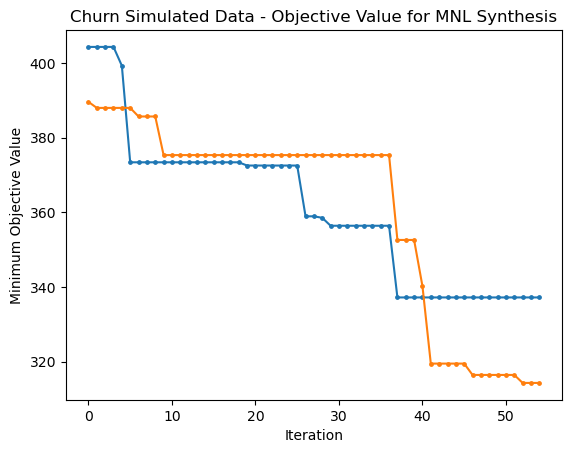

In [11]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Churn Simulated Data - Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
# fig.savefig('../Images/min_objective_mnl_ipums.pdf')
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [12]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [13]:
best_params

{'target': -314.26588619710327,
 'params': {'C_hiking_int': 0.5895434689050837,
  'C_online_int': 0.05623135034617935,
  'C_sustain_int': 0.6598139700943358}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [14]:
pmse_ratios, full_sXs = train_models_mn(train_data=train_data,
                                        num_vars_synthesized=3,
                                        poly_degree_pmse=3,
                                        number_synthetic_datasets=20,
                                        # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                        C_hiking_int=best_params['params']['C_hiking_int'],
                                        C_sustain_int=best_params['params']['C_sustain_int'],
                                        C_online_int=best_params['params']['C_online_int'])

C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
np.mean(pmse_ratios)

19.01153945566746

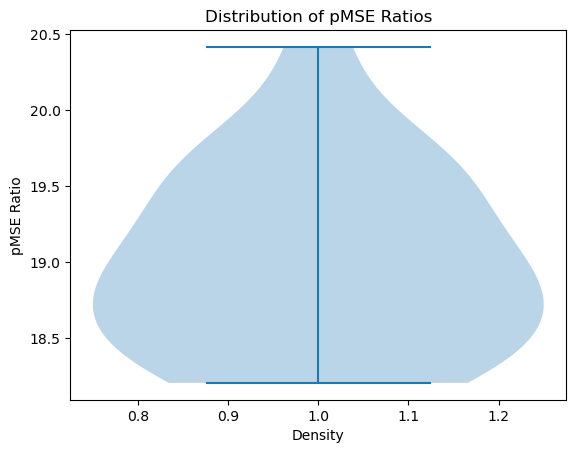

In [16]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [17]:
synthetic_data_path = "../../Data/Simulations/Churn/"

for i, sX in enumerate(full_sXs):
    if not os.path.exists(synthetic_data_path):
        os.makedirs(synthetic_data_path)
    sX.to_csv(synthetic_data_path + "mnl_" + str(i) + ".csv", index=False)

In [10]:
# full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

# # load
# with open('../Results/IPUMS/Models/gmm_and_mnl.pkl', 'rb') as f:
#     GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [11]:
# prior = np.mean(train_data.non_white == 1)

In [12]:
# prior

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [13]:
# c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [14]:
# deltas = np.linspace(0.001, 0.1, 5)

In [15]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
#                                          categorical_vars=['sex'],
#                                          sensitive_var='non_white',
#                                          num_mixture_components=190,#int(best_params['params']['num_components_']),
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

***

In [16]:
# num_records = train_data.shape[0]

In [17]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])

***

In [18]:
# for i, sX in enumerate(ad_sXs):
    
#     # normalize
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])

#     # convert to original scale (un-normalize?)
#     H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
#     scaler = StandardScaler().fit(H.loc[:, ['incwage', 'years_of_educ', 'potential_experience']])
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)
#     full_sXs[i].to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)